# Исследование объявлений о продаже квартир

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Цель-анализа-и-исходные-данные" data-toc-modified-id="Цель-анализа-и-исходные-данные-1">Цель анализа и исходные данные</a></span></li><li><span><a href="#Шаг-1.-Общая-информация" data-toc-modified-id="Шаг-1.-Общая-информация-2">Шаг 1. Общая информация</a></span></li><li><span><a href="#Шаг-2.-Предобработка-данных" data-toc-modified-id="Шаг-2.-Предобработка-данных-3">Шаг 2. Предобработка данных</a></span></li><li><span><a href="#Шаг-3.-Добавление-дополнительных-параметров" data-toc-modified-id="Шаг-3.-Добавление-дополнительных-параметров-4">Шаг 3. Добавление дополнительных параметров</a></span></li><li><span><a href="#Шаг-4.--Исследовательский-анализ-данных" data-toc-modified-id="Шаг-4.--Исследовательский-анализ-данных-5">Шаг 4.  Исследовательский анализ данных</a></span></li><li><span><a href="#Шаг-5.-Общий-вывод" data-toc-modified-id="Шаг-5.-Общий-вывод-6">Шаг 5. Общий вывод</a></span></li></ul></div>

## Цель анализа и исходные данные

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно определить рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

Описание данных
* airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
* balcony — число балконов
* ceiling_height — высота потолков (м)
* cityCenters_nearest — расстояние до центра города (м)
* days_exposition — сколько дней было размещено объявление (от публикации до снятия)
* first_day_exposition — дата публикации
* floor — этаж
* floors_total — всего этажей в доме
* is_apartment — апартаменты (булев тип)
* kitchen_area — площадь кухни в квадратных метрах (м²)
* last_price — цена на момент снятия с публикации
* living_area — жилая площадь в квадратных метрах(м²)
* locality_name — название населённого пункта
* open_plan — свободная планировка (булев тип)
* parks_around3000 — число парков в радиусе 3 км
* parks_nearest — расстояние до ближайшего парка (м)
* ponds_around3000 — число водоёмов в радиусе 3 км
* ponds_nearest — расстояние до ближайшего водоёма (м)
* rooms — число комнат
* studio — квартира-студия (булев тип)
* total_area — площадь квартиры в квадратных метрах (м²)
* total_images — число фотографий квартиры в объявлении

Пояснение: апартаменты — это нежилые помещения, не относящиеся к жилому фонду, но имеющие необходимые условия для проживания.

## Шаг 1. Общая информация

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 

In [1]:
data = pd.read_csv('/datasets/real_estate_data.csv', '\t')
data.info()
print()
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

Методом **.info()** выявлены пропуски:
1. ceiling_height - 9195 пропусков. 
   *Высота потолков - не самый обязательный параметр, пропуски допустимы. Но слишком большой разброс значений может наводить на мысль о потенциальных ошибках выгрузки в комбинации с ошибками, допущенной пользователями. Нужно проверять имеют ли они техногенный анализ.*
    
2. floors_total - 86 пропусков. *Вероятен человеческий фактор. Вообще в системе должны быть обязательные пункты, без которых публикация невозможна.*
    
3. living_area - 1903 пропусков.*Вероятен человеческий фактор. 
    
4. **is_apartment** - 20924 пропусков.
    Если человек не указал, что это аппартаменты — скорее всего, это обычная квартира. Заменим пропуски на 0.
5. kitchen_area - 2278 пропусков.
    
6. **balcony** - 11519 пропусков.
    Если человек не указал число балконов — скорее всего, их нет. Заменим пропуски на 0.
7. **locality_name** - 49 пропусков.
    То что пропуски в названиях есть, а расстояние до парка, к примеру, в большинстве случаев есть, свидетельствуют о явной ошибке в выгрузке данных. Заполнять такое поле не будем. 
    
8. **days_exposition** - 3181 пропусков. *Техногенный фактор/ошибка в методологии рассчетов. Нужно консультироваться с программистами, которые описывали этот параметр.
    
9.  airports_nearest - 5542 пропусков.
    cityCenters_nearest - 5519 пропусков.
    parks_around3000 - 5518 пропусков.
    parks_nearest -  15620 пропусков.
    ponds_around3000 - 5518 пропусков.
    ponds_nearest - 14589 пропусков.
    *Так как все эти значения получены на основе картографических данных, вероятно, этот параметр не подходит для данного объявления.*

## Шаг 2. Предобработка данных

In [2]:
data = pd.DataFrame(data)

data['first_day_exposition'] = pd.to_datetime(
    data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S') #преобразование даты
data['balcony'] = data['balcony'].fillna(0).astype('int') #преобразование типа
data['last_price'] = data['last_price'].astype('int') #преобразование типа
data['is_apartment'] = data['is_apartment'].fillna(False).astype('bool') #преобразование типа с заменой, описанной выше
print('Количество строк в источкике ', data['last_price'].count()) 

# Типизируем название в колонке с населенным пунктом, сделаем его сокращенным
delete_name = ['городской поселок ', 'деревня ', 
                   'поселок городского типа ', 'село ', 'поселок при железнодорожной станции ',
                  'поселок станции ', 'поселок ']

for each in delete_name:
    data['locality_name'] = (data['locality_name']
                    .str.replace('ё','е') # Самое распространенное повторение названий с разным написанием букв
                    .str.replace(each,'') # Удалим лишнее
                   # .str.replace('коттеджный ','кп') # Исключение - вернем полное название для коттеджных поселков
                            )

# data[data['locality_name'].str.count(' ')>0]['locality_name'].unique() # Проверили корректность длинных названий  
data = data.drop_duplicates().reset_index(drop=True) # Удалим дубликаты, если они есть
print('Количество строк без дубликатов ', data['last_price'].count()) # Количество оставшихся строк


Количество строк в источкике  23699
Количество строк без дубликатов  23699


Тип данных необходимо поменять в следущих колонках: 
1. **first_day_exposition** - в тип даты для расчетов и для удобства чтения
2. **balcony** - после замены пропусков можно сменить тип на целочисленный
3. **is_apartment** - после замены пропусков можно сменить тип на логический, для удобства расчетов
4. **last_price** - заменим тип на целочисленный, для удобства расчетов и отображения значений
 
В остальных случаях замена на целочисленный тип либо не нужна (например, в случае с высотой потолков, там могут быть не целые числа), либо замена не получится из-за наличия пустых значений тип данных. 

## Шаг 3. Добавление дополнительных параметров

In [3]:
data['price_square_meter'] = data['last_price'] / data['total_area'] # цену квадратного метра
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year # день недели
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month # месяц
data['dayOfWeek'] = pd.DatetimeIndex(data['first_day_exposition']).dayofweek # год публикации объявления
data['floor_type'] = ( # этаж квартиры
    data['floor']
    .where((data['floor'] == 1) & (data['floor'] == data['floors_total']) , 'другой') 
    # другой - пусть будет даже в случаях пропуска поля этажей всего, так как значений немного
    .where((data['floor'] != data['floors_total']), 'последний')
    .where((data['floor'] != 1), 'первый')
)  
data['living_to_total'] = data['living_area'] / data['total_area'] # соотношение жилой и общей площади
data['kitchen_to_total'] = data['kitchen_area'] / data['total_area'] # отношение площади кухни к общей
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_square_meter,year,month,dayOfWeek,floor_type,living_to_total,kitchen_to_total
0,20,13000000,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,2.0,755.0,NaN,120370.370370,2019,3,3,другой,0.472222,0.231481
1,7,3350000,40.4,2018-12-04,1,NaN,11.0,18.6,1,False,...,0.0,NaN,81.0,82920.792079,2018,12,1,первый,0.460396,0.272277
2,10,5196000,56.0,2015-08-20,2,NaN,5.0,34.3,4,False,...,2.0,574.0,558.0,92785.714286,2015,8,3,другой,0.612500,0.148214
3,0,64900000,159.0,2015-07-24,3,NaN,14.0,NaN,9,False,...,3.0,234.0,424.0,408176.100629,2015,7,4,другой,NaN,NaN
4,2,10000000,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,1.0,48.0,121.0,100000.000000,2018,6,1,другой,0.320000,0.410000


In [4]:
incorrect_area = data.query('(kitchen_area + living_area) > total_area')
incorrect_area['total_area'].count()

64

*Обнаружено несоответствие суммы жилой и кухонной площадей - общей. Не будем их учитывать при анализе влияния площади квартиры на стоимость.*

In [5]:
data['living_to_total'].where((data['kitchen_area'] + data['living_area']) <= data['total_area'], None)
data['kitchen_to_total'].where((data['kitchen_area'] + data['living_area']) <= data['total_area'], None)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_square_meter,year,month,dayOfWeek,floor_type,living_to_total,kitchen_to_total
0,20,13000000,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,2.0,755.0,NaN,120370.370370,2019,3,3,другой,0.472222,0.231481
1,7,3350000,40.4,2018-12-04,1,NaN,11.0,18.6,1,False,...,0.0,NaN,81.0,82920.792079,2018,12,1,первый,0.460396,0.272277
2,10,5196000,56.0,2015-08-20,2,NaN,5.0,34.3,4,False,...,2.0,574.0,558.0,92785.714286,2015,8,3,другой,0.612500,0.148214
3,0,64900000,159.0,2015-07-24,3,NaN,14.0,NaN,9,False,...,3.0,234.0,424.0,408176.100629,2015,7,4,другой,NaN,NaN
4,2,10000000,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,1.0,48.0,121.0,100000.000000,2018,6,1,другой,0.320000,0.410000


Добавлены новые вычисляемые столбцы. 
Отметим, что этажность зданий есть не везде, но так как значений не много, поместили эти объявления в группу этажей "Другие". 


## Шаг 4.  Исследовательский анализ данных

In [6]:
print(data[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe())
data.sort_values(by='last_price').head()

         total_area    last_price         rooms  ceiling_height
count  23699.000000  2.369900e+04  23699.000000    14504.000000
mean      60.348651  6.541549e+06      2.070636        2.771499
std       35.654083  1.088701e+07      1.078405        1.261056
min       12.000000  1.219000e+04      0.000000        1.000000
25%       40.000000  3.400000e+06      1.000000        2.520000
50%       52.000000  4.650000e+06      2.000000        2.650000
75%       69.900000  6.800000e+06      3.000000        2.800000
max      900.000000  7.630000e+08     19.000000      100.000000


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_square_meter,year,month,dayOfWeek,floor_type,living_to_total,kitchen_to_total
8793,7,12190,109.0,2019-03-20,2,2.75,25.0,32.0,25,False,...,0.0,NaN,8.0,111.834862,2019,3,2,последний,0.293578,0.371560
17456,7,430000,30.4,2019-04-22,1,NaN,2.0,16.0,1,False,...,NaN,NaN,NaN,14144.736842,2019,4,0,первый,0.526316,0.197368
14911,5,430000,54.0,2018-06-26,2,NaN,3.0,NaN,3,False,...,NaN,NaN,44.0,7962.962963,2018,6,1,последний,NaN,NaN
16274,18,440000,40.0,2018-07-10,1,NaN,5.0,NaN,1,False,...,NaN,NaN,45.0,11000.000000,2018,7,1,первый,NaN,NaN
17676,0,450000,36.5,2018-02-01,1,NaN,5.0,17.3,4,False,...,NaN,NaN,120.0,12328.767123,2018,2,3,другой,0.473973,0.232877


Уже методом **.describe()** видно, что есть выпадающие из логики значения:
- Количество комнат = 0. Даже в студиях обычно не указывают значение комнат как 0. Исправим это
- Максимальная высота потолков - 100. Минимальная - 1м
- Явно выбивающийся минимум в стоимости = 12190. Следущее после него значение =430тыс

In [7]:
print('Нулевые значения комнат -', data[data['rooms'] == 0]['rooms'].count()) # 197 значений, не так уж много
# предположим опечатку в написании объявления. Заменим занчения на 1, это не повлияет на общее распределение
data['rooms'] = data['rooms'].where(data['rooms'] != 0, 1)

Нулевые значения комнат - 197


In [8]:
data.query('last_price>100000', inplace=True) #удаляем выбивающийся минимум

In [9]:
# отметим максимальную высоту потолка равную 5 метрам 
print('Слишком высокие потолки -', data[data['ceiling_height'] > 5]['rooms'].count()) # 36 значений, не так уж много
print('Слишком низкие потолки -', data[data['ceiling_height'] < 2.4]['rooms'].count()) # 21 значения
(data['ceiling_height']
 .where((data['ceiling_height'] < 25) & (data['ceiling_height']!= 100), 
        data['ceiling_height']/10, inplace =True)
)
(data['ceiling_height']
 .where((data['ceiling_height'] < 5), 
        data['ceiling_height'].median(), inplace =True)
)
(data['ceiling_height']
 .where((data['ceiling_height'] > 2.4), 
        data['ceiling_height'].median(), inplace =True)
)

Слишком высокие потолки - 36
Слишком низкие потолки - 21


*В зданиях старой постройки размеры помещений могут быть увеличены, в результате чего высота потолка может превысить отметку в 4 метра. Минимальная высота - 2,4м. 
Некорректных значений не много. Предположим, что в значениях высоты потолка от 25 до 32, была допущена опечатка, и там не хватает запятой. При ее наличии цифры похожи на правду. 
Остальные выпадающие значения заменим на медиану.* - Информация из интернета

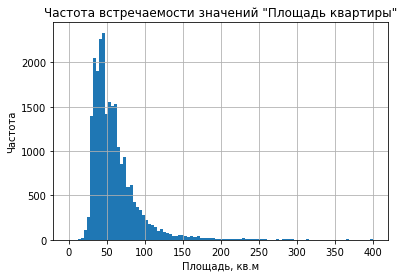

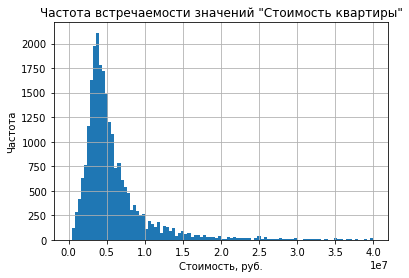

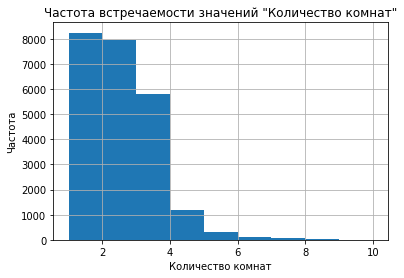

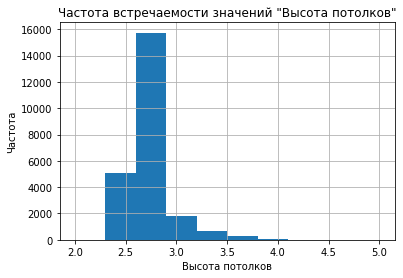

In [10]:
# Построим гистограммы частоты появления значений

data['total_area'].plot(kind='hist', bins=100, range=(0, 400), grid=True)
plt.title('Частота встречаемости значений "Площадь квартиры"')
plt.ylabel('Частота')
plt.xlabel('Площадь, кв.м')

data.hist('last_price', bins=100, range=(10000, 40000000)); # цена
plt.title('Частота встречаемости значений "Стоимость квартиры"')
plt.ylabel('Частота')
plt.xlabel('Стоимость, руб.')


data.hist('rooms', bins=9, range=(1, 10)); # число комнат
plt.title('Частота встречаемости значений "Количество комнат"')
plt.ylabel('Частота')
plt.xlabel('Количество комнат')


data.hist('ceiling_height', bins=10, range=(2, 5)); # высота потолков
plt.title('Частота встречаемости значений "Высота потолков"')
plt.ylabel('Частота')
plt.xlabel('Высота потолков');

1. Достаточно большое количество квартир с площадью менее 50кв.м, что наталкивает на мысль о большом количестве коммунальных квартир.
2. Пик значений стоимости приходится менее чем на 5млн.руб. 
3. Самые популярные квартиры с 2-3 комнатами.
Все графики, кроме "Высоты потолков", напоминают Пуассоновское распределение
4. Для высоты потолков, видимо, есть какой то стандарт (примерно, от 2,4 до 3 м), остальные значения можно назвать редким исключением.

**На данный момент распределение значений показателей кажется логичным.**

Среднее время продажи 180
Медианное время продажи 95



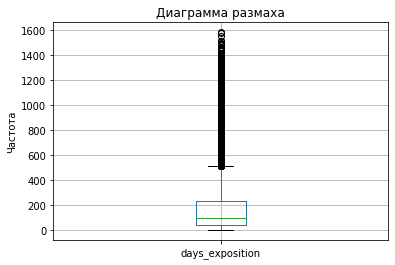

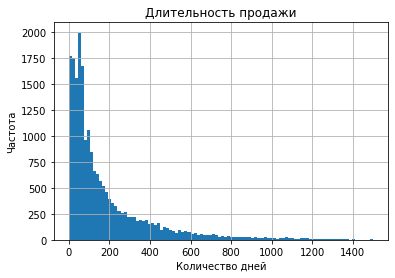

In [11]:
# Изучим время продажи квартиры
days_mean_Orig = data['days_exposition'].mean().astype('int') # Исходное значение среднего
days_median_Orig = data['days_exposition'].median().astype('int') # Исходное значение медианы
print('Среднее время продажи {}'.format(days_mean_Orig))
print('Медианное время продажи {}'.format(days_median_Orig))
print()
# Посмотрим ящик с усами на графике
Box = pd.DataFrame(data['days_exposition']) 
Q1 = Box.quantile([0.25], interpolation='nearest') # быстрое время продажи
Q2 = Box.quantile([0.50], interpolation='nearest') # нормальное время продажи
Q3 = Box.quantile([0.75], interpolation='nearest') # долгое время продажи

#print(Box.describe())

Box.boxplot()
plt.title('Диаграмма размаха')
plt.ylabel('Частота')

# Выведем график с частотой появления значений
data.hist('days_exposition', bins=100, range=(0,1500))
plt.title('Длительность продажи')
plt.ylabel('Частота')
plt.xlabel('Количество дней');

1. Значение около 512 - это ориентировочная граница нормального размаха. Всё, что лежит за ней, считается выбросом. Более высокие значения рисуются отдельными точками, но сливаются в единую жирную линию: таких выбросов у нас очень много.
Нетипично долгие объявления признаем выбросами и отбросим.
Потому-что, во-первых, их немного. Во-вторых, скорее всего, такие значения — не корректные. Например, продавец мог забыть снять его с продажи.
Примем верхнюю границу в 600 дней.

2. Наблюдается 2 мощных пика, нарущающие равномерность распределения
 
3. Итого, отталкиваясь от квартилей, быстрое время продажи - до 45 дней, среднее - до 95, долгое - 232 и выше

In [12]:
print(data.query('days_exposition >=600')['days_exposition'].count()) # Не будем учитывать такие объявления на графике
data = data.query('days_exposition <600')

1202


1622


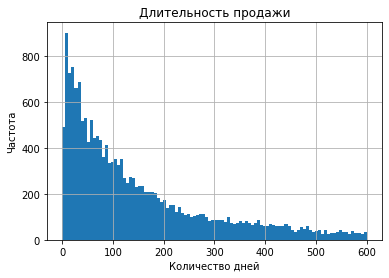

In [13]:
# Посчитаем количество значений в пиках. Без округления условие не работает, видимо значение 45 - не точное
data['days_exposition'] = data['days_exposition'].round()
print(data.query('(days_exposition == 45) | days_exposition ==60 | days_exposition ==90')['days_exposition'].count())
# Посмотрим, как будет выглядеть распределение без этих пиков
(data.query('(days_exposition != 45) & days_exposition !=60 & days_exposition !=90')
    .hist('days_exposition', bins=100, range=(0,600)))
plt.title('Длительность продажи')
plt.ylabel('Частота')
plt.xlabel('Количество дней');

*Экспериментально выявлено, что 2 пика находятся в районе 45 (880шт) и 60 (538) дней. +На графике теперь стало заметно еще одно значение в районе 90.
Конечно, если убрать эти значения, получим, что распределение почти, за еще некоторыми исключениями, стремится к Пуассоновскому.
Однако не брать их во внимание у нас пока нет причин. Может это как-то связано с условиями размещения объявлений или еще чем-то, нужно уточнять.*

Среднее время продажи 139
Медианное время продажи 89


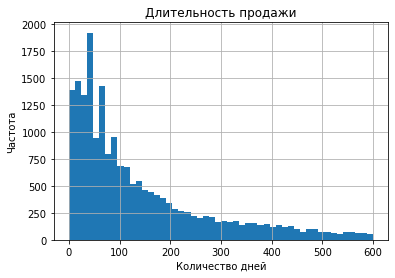

In [14]:
data.query('days_exposition <600 | days_exposition.isna()', inplace= True)  # Убераем выбросы
days_mean_Modif = data['days_exposition'].mean().astype('int') # Исходное значение среднего
days_median_Modif = data['days_exposition'].median().astype('int') # Исходное значение медианы
print('Среднее время продажи {}'.format(days_mean_Modif))
print('Медианное время продажи {}'.format(days_median_Modif))

# Выведем график с частотой появления значений
data.hist('days_exposition', bins=50, range=(0,600))
plt.title('Длительность продажи')
plt.ylabel('Частота')
plt.xlabel('Количество дней');

Несколько изменилось медианное значение дней, среднее изменилось сильнее. 

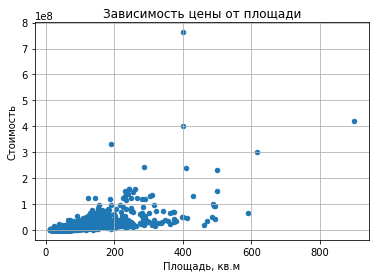

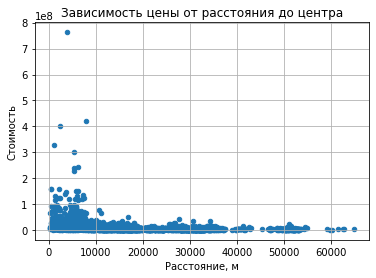

In [15]:
# Зависимость цены от площади и растояния до центра
graphs = [
    {'col': 'total_area', 'title': 'Зависимость цены от площади', 'xlabel': 'Площадь, кв.м', 'ylabel': 'Стоимость'},
    {'col': 'cityCenters_nearest', 'title': 'Зависимость цены от расстояния до центра', 'xlabel': 'Расстояние, м', 'ylabel': 'Стоимость'},
]
for graph in graphs:
    data.sort_values(by = graph['col']).plot(x=graph['col'], y='last_price', kind='scatter', grid=True)
    plt.title(graph['title'])
    plt.xlabel(graph['xlabel'])
    plt.ylabel(graph['ylabel'])
    plt.show()

Данные по зависимости цены от растояния до центра выглядят логичными. Пики наблидаются вблизи центра города. 
Данные по зависимости цены от площади квартиры тоже приемлемы. Чем больще площадь, тем выше цена. 
А низкие значения цены вблизи центра или с больщой площадью можно объяснить выборкой за разные года.

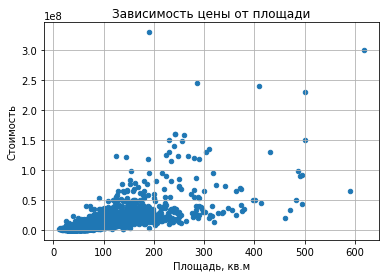

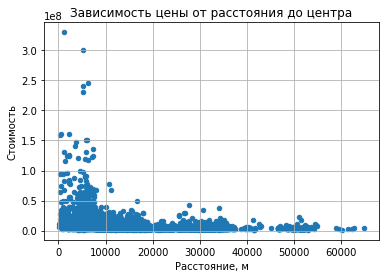

In [16]:
# Заметно выбивается 3 значения цены больше 4*10^8, они может влиять на среднее, поэтому не будем его учитывать
data = data[data['last_price']<400000000].reset_index()
for graph in graphs:
    data.sort_values(by = graph['col']).plot(x=graph['col'], y='last_price', kind='scatter', grid=True)
    plt.title(graph['title'])
    plt.xlabel(graph['xlabel'])
    plt.ylabel(graph['ylabel'])
    plt.show()

In [17]:
data.pivot_table(index='year', values= 'last_price', aggfunc=['count', 'mean']) #  просмотр кол-ва данных по годам

,count,mean
,last_price,last_price
year,,
2014,28,1.005981e+07
2015,595,7.997827e+06
2016,2267,6.292304e+06
2017,7780,6.266828e+06
2018,7560,5.610801e+06
2019,1082,5.873946e+06


В 2014 был максимум средней стоимости, это можно объяснить тем, что там гораздо меньше значений -46.
Такое сравнение нельзя назвать корректным, поэтому возьмем данные от 2015г и выше

In [18]:
data = data[data['year']>2014]

Динамика цен недвижимости / Зависимость цены от даты размещения объявления


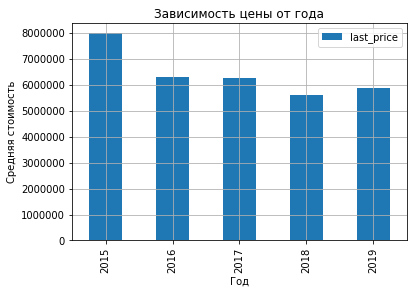

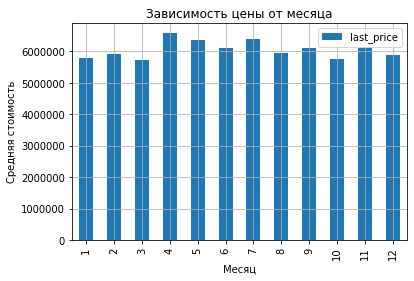

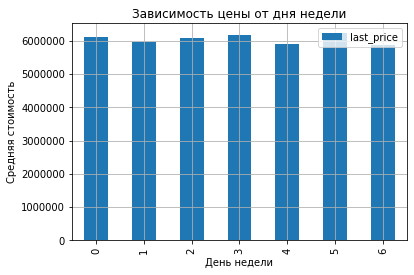

In [19]:
# Зависимость цены от даты размещения 
graphs = [
    {'col': 'year', 'title': 'Зависимость цены от года', 'xlabel': 'Год', 'ylabel': 'Средняя стоимость'},
    {'col': 'month', 'title': 'Зависимость цены от месяца', 'xlabel': 'Месяц', 'ylabel': 'Средняя стоимость'},
    {'col': 'dayOfWeek', 'title': 'Зависимость цены от дня недели', 'xlabel': 'День недели', 'ylabel': 'Средняя стоимость'}
]
print('Динамика цен недвижимости / Зависимость цены от даты размещения объявления')
for graph in graphs:
    (data.pivot_table(index=graph['col'], values= 'last_price', aggfunc='mean')
        .sort_values(graph['col'])
        .plot(kind='bar', grid=True)
    )
    plt.title(graph['title'])
    plt.xlabel(graph['xlabel'])
    plt.ylabel(graph['ylabel'])
    plt.show()
    

Выставленная стоимость независит от дня недели, немного зависит от месяца (есть небольшой рост в апреле, июле, спад в первые 3 месяца и в октябре).
Зато наблюдается зависимость от года публикации, дешевле всего квартиры были в 2018г. 

In [20]:
# Зависимость цены от количества комнат 
print(data.pivot_table(index='rooms', values= 'last_price', aggfunc=['count', 'mean'])
        .sort_values('rooms')
    )
data.query('rooms <8', inplace= True)

           count          mean
      last_price    last_price
rooms                         
1           7117  3.763465e+06
2           6543  5.355843e+06
3           4462  7.772756e+06
4            837  1.290830e+07
5            208  2.256538e+07
6             67  3.732479e+07
7             33  4.172364e+07
8              8  4.678625e+07
9              3  2.882297e+07
10             2  2.775000e+07
14             2  2.682950e+07
15             1  6.500000e+07
19             1  3.225000e+07


**Очень сильно выбиваются по цене квартиры с 15 комнатами. И вообще, после 11 комнат, их количество идет подозрительно не по порядку, а объявлений c количеством комнат >8 крайне мало. Отсеим значения комнат больше 8. Иначе они будут перетягивать среднее**

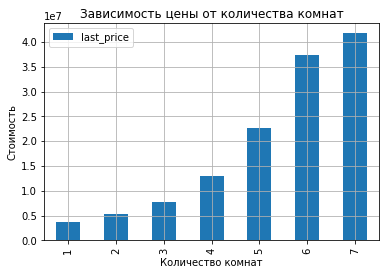

In [21]:
(data.pivot_table(index='rooms', values= 'last_price', aggfunc='mean')
        .sort_values('rooms')
        .plot(kind='bar', grid=True, label='Стоимость')
    )
plt.title('Зависимость цены от количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Стоимость');

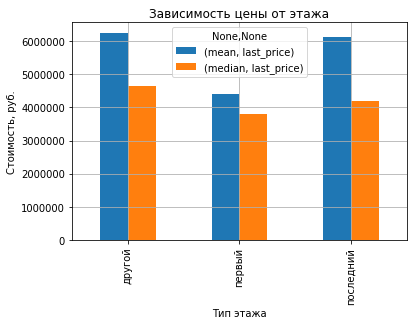

In [22]:
# Зависимость цены от того, на каком этаже расположена квартира
(data.pivot_table(index='floor_type', values= 'last_price', aggfunc=['mean','median'])
        .sort_values('floor_type')
        .plot(kind='bar', grid=True)
    )
plt.title('Зависимость цены от этажа')
plt.ylabel('Стоимость, руб.')
plt.xlabel('Тип этажа');

По статистике, хуже всего покупают квартиры на первых этажах и не так охотно на последних (за исключением пентхаусов и элитных домов), а остальные как раз имеют больше привлекательности для покупателей. Собственно от этого и зависит стоимость жилья. Наше медианное значение укладывается в эту логику. Если брать среднее значение, то на первом месте "Последние" этажи, это как раз говорит о том, что это смещение обеспечивают дорогие квартиры.

min  600000
max  330000000


price_square_meter                last_price           
                             count           mean        min        max
locality_name                                                          
Санкт-Петербург              12754  111600.447923    1190000  330000000
Мурино                         531   85879.629975    1730000    7940000
Кудрово                        417   94662.809738    1800000   13000000
Шушары                         394   77969.020793    1500000   10700000
Всеволожск                     317   68690.067876     965780   24412900
Колпино                        297   74641.187278    2100000   12750000
Парголово                      293   89300.793104    1400000    9140000
Пушкин                         287  101894.382804    1990000   42000000
Гатчина                        250   68126.394821     850000   12700000
Выборг                         196   57076.593609     600000    7490000

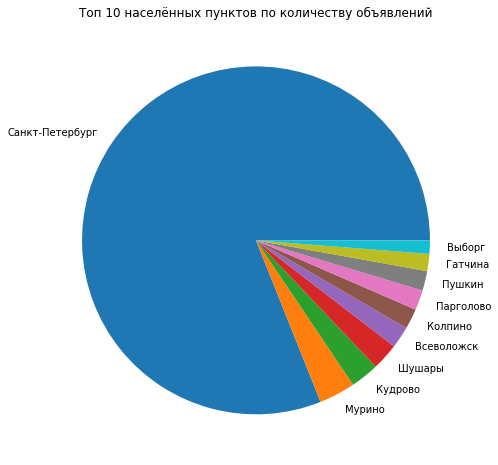

In [23]:
# Топ 10 населённых пунктов
top10 = (
    data.groupby('locality_name')
    .agg({'price_square_meter': ['count', 'mean'], 'last_price': ['min','max']})
    .sort_values(('price_square_meter','count'), ascending=False).head(10)
    )
print('min ', top10[('last_price', 'min')].min())
print('max ', top10[('last_price', 'max')].max())
top10['price_square_meter','count'].plot(y='count', kind='pie', figsize=(8,8))
plt.title('Топ 10 населённых пунктов по количеству объявлений')
plt.ylabel('')
top10

Для наглядности оставим и количество значений, чтобы видеть, что данных из Спб у нас больше всего. Максимальное значение стоимости находится как раз в Петербурге, а минимальное в Выборге.

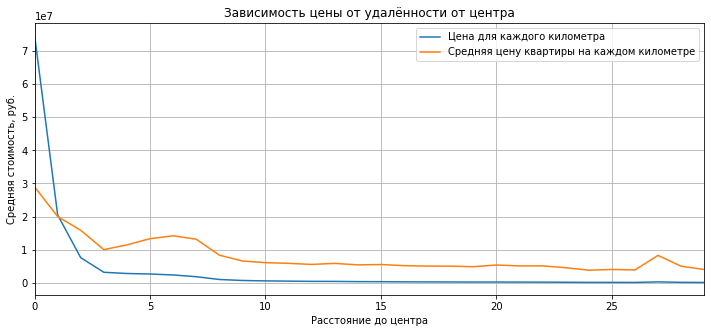

In [24]:
# Посмотрим, как цена зависит от удалённости от центра
data['centerKm'] = (data['cityCenters_nearest']/1000)
# Будем смотреть только те объявления, где указано расстояние до центра
locality = data.query('locality_name == "Санкт-Петербург" & cityCenters_nearest>=0 ').reset_index() 
#1. Посчитаем среднюю цену для каждого километра.
locality['price_centerKm'] =locality['last_price'] / locality['centerKm']
locality['centerKm'] = locality['centerKm'].round()
locality.groupby('centerKm')['price_centerKm'].mean().plot(grid=True, figsize=(12,5)) 
#2. Посчитаем среднюю цену квартиры на каждом километре.
price_centerKm = locality.groupby('centerKm')['last_price'].mean()
price_centerKm.plot(grid=True, figsize=(12,5))
plt.title('Зависимость цены от удалённости от центра')
plt.ylabel('Средняя стоимость, руб.')
plt.xlabel('Расстояние до центра')
plt.legend(['Цена для каждого километра', 'Средняя цену квартиры на каждом километре']);

Оба графика меняются в районе 3-х км, — это и будет центральная зона.

Частота значений площади


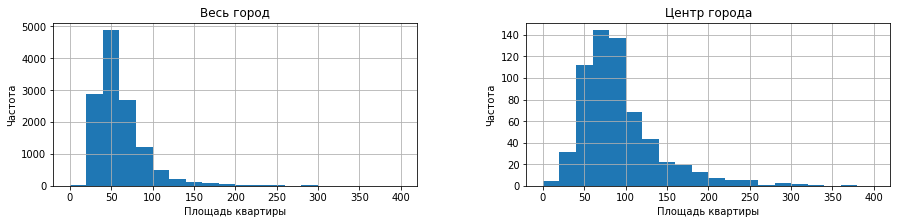

In [25]:
# Сегмент квартир в центре
locality['center_3km'] = locality[locality['centerKm'] <= 3]['centerKm']
#Проанализируем эту территорию и изучим следующие параметры: площадь, цена, число комнат, высота потолков

print('Частота значений площади')
fig, axes =plt.subplots(1,2,figsize=(15,3))
(locality.hist('total_area', bins=20, range=(0,400), ax=axes[0]))
axes[0].set_title('Весь город')
axes[0].set_ylabel('Частота')
axes[0].set_xlabel('Площадь квартиры')

(locality[locality['center_3km']>=0].hist('total_area',ax=axes[1], bins=20, range=(0,400)))
axes[1].set_title('Центр города')
axes[1].set_ylabel('Частота')
axes[1].set_xlabel('Площадь квартиры');


Из данной выборки следует, что в центре чаще встречаются квартиры с большой площадью.

Частота значений стоимости


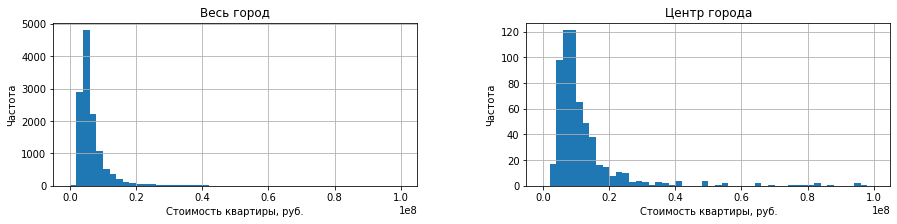

In [26]:
print('Частота значений стоимости')
fig, axes =plt.subplots(1,2,figsize=(15,3))
(locality.hist('last_price', bins=50, range=(0,100000000), ax=axes[0]))
axes[0].set_title('Весь город')
axes[0].set_ylabel('Частота')
g

(locality[locality['center_3km']>=0].hist('last_price',ax=axes[1], bins=50, range=(0,100000000)))
axes[1].set_title('Центр города')
axes[1].set_ylabel('Частота')
axes[1].set_xlabel('Стоимость квартиры, руб.');


В центре города чаще встречаются дорогие квартиры. Но распределение повторяемости графиков похоже

Частота значений количества комнат


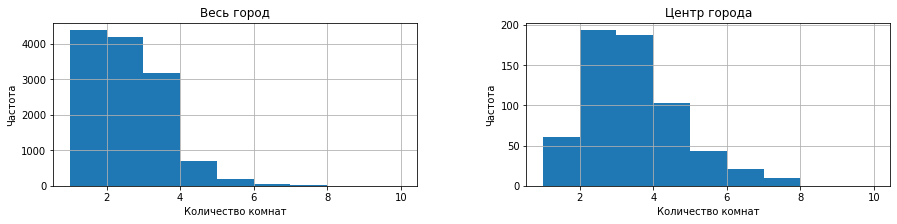

In [27]:
print('Частота значений количества комнат')
fig, axes =plt.subplots(1,2,figsize=(15,3))
(locality.hist('rooms', bins=9, range=(1,10), ax=axes[0]))
axes[0].set_title('Весь город')
axes[0].set_ylabel('Частота')
axes[0].set_xlabel('Количество комнат')

(locality[locality['center_3km']>=0].hist('rooms',ax=axes[1], bins=9, range=(1,10)))
axes[1].set_title('Центр города')
axes[1].set_ylabel('Частота')
axes[1].set_xlabel('Количество комнат');


Однокомнатных квартир в центре города гораздо меньше

Частота значений высоты потолков


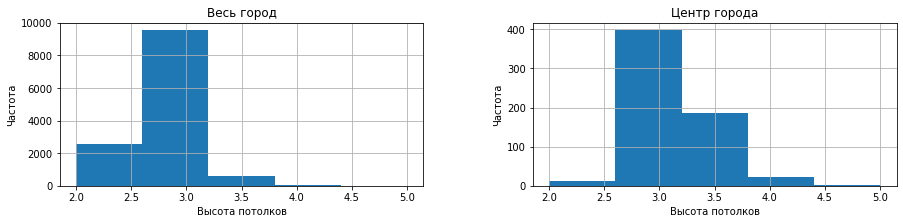

In [28]:
print('Частота значений высоты потолков')
fig, axes =plt.subplots(1,2,figsize=(15,3))
(locality.hist('ceiling_height', bins=5, range=(2,5), ax=axes[0]))
axes[0].set_title('Весь город')
axes[0].set_ylabel('Частота')
axes[0].set_xlabel('Высота потолков')

(locality[locality['center_3km']>=0].hist('ceiling_height',ax=axes[1], bins=5, range=(2,5)))
axes[1].set_title('Центр города')
axes[1].set_ylabel('Частота')
axes[1].set_xlabel('Высота потолков');

В центре города чаще встречаются квартивы с более высокими потолками

**В целом, динамика параметров квартир в центре повторяет динамику этих же параметров по всему городу. 
Средняя площадь квартир в центре, чуть выше. Однокомнатных квартир в центре меньше.**

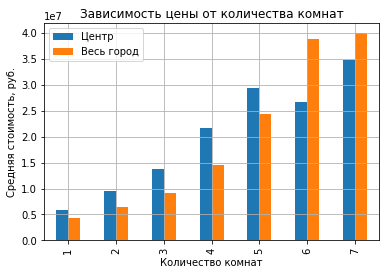

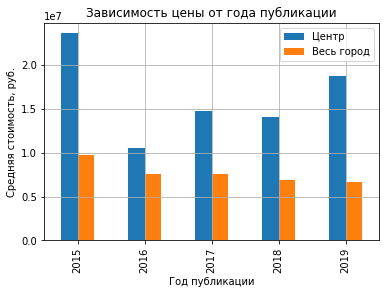

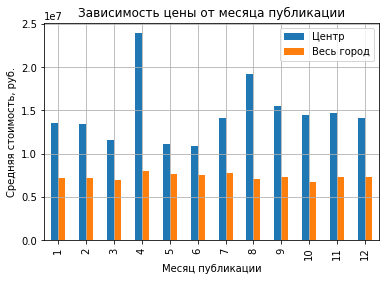

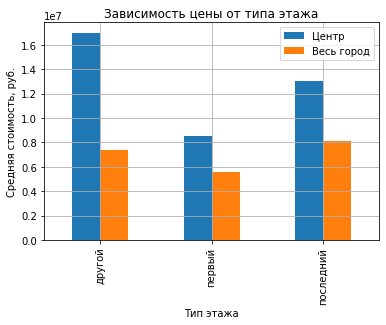

In [29]:
# факторы, которые влияют на стоимость квартиры

parametrs = [{'col': 'rooms', 'title': 'Зависимость цены от количества комнат', 'xlabel': 'Количество комнат'},
    {'col': 'year', 'title': 'Зависимость цены от года публикации', 'xlabel': 'Год публикации'},
    {'col': 'month', 'title': 'Зависимость цены от месяца публикации', 'xlabel': 'Месяц публикации'},
    {'col': 'floor_type', 'title': 'Зависимость цены от типа этажа', 'xlabel': 'Тип этажа'}]
for each in parametrs:
    all_city = locality.pivot_table(index=each['col'], values= 'last_price')
    center = locality[locality['center_3km']>=0].pivot_table(index=each['col'], values='last_price')
    city_center = center.merge(all_city, on = each['col'], how='left')
    city_center.columns = ['center','all_city']
    city_center.plot(kind='bar', grid=True)
    plt.title(each['title'])
    plt.xlabel(each['xlabel'])
    plt.ylabel('Средняя стоимость, руб.')
    plt.legend(['Центр', 'Весь город']);

In [30]:
#Посмотрим, почему 6-7к квартиры в центре стоят дешевле
print(locality[locality['center_3km']>=0].pivot_table(index='rooms', values= 'last_price', aggfunc=['count', 'mean'])
        .sort_values('rooms')
    )

           count          mean
      last_price    last_price
rooms                         
1             61  5.802293e+06
2            193  9.452767e+06
3            188  1.369406e+07
4            103  2.165967e+07
5             43  2.927716e+07
6             21  2.660062e+07
7             10  3.476400e+07


По большому счету, средняя цена квартиры в центре Спб всегда выше стоимости квартир по городу. 6-7к квартир в центре очень мало, поэтому учитывать их данные будет не совсем корректно. 
В остальном, динамика роста цены в зависимости от кол-ва комнат и от этажа одинакова по городу.
А вот дата (год и месяц) влияют на цены по-разному.
Дешевле всего квартиры в центре были в 2016, в мае месяце тоже наблюдается резкое снижение по всех годам. 
Стоит отметить, что 2014 стал годом "рекордного" жилья, из за кризиса и роста курса доллара, далее цена снизилась и к 2019г не побила кризисных максимумов.

## Шаг 5. Общий вывод

In [31]:
data[['last_price', 'total_area', 'rooms', 'floor_type', 'days_exposition', 'ceiling_height', 'centerKm']].describe()

,last_price,total_area,rooms,days_exposition,ceiling_height,centerKm
count,1.926700e+04,19267.000000,19267.000000,19267.000000,19267.000000,14866.000000
mean,6.014708e+06,57.743386,2.003945,138.383298,2.686617,14.434729
std,8.183329e+06,31.376811,0.985088,135.875260,0.198040,8.469158
min,4.300000e+05,12.000000,1.000000,1.000000,2.450000,0.208000
25%,3.390000e+06,39.100000,1.000000,42.000000,2.600000,9.781000
50%,4.500000e+06,50.000000,2.000000,89.000000,2.650000,13.265000
75%,6.400000e+06,67.000000,3.000000,194.000000,2.700000,16.453000
max,3.300000e+08,618.000000,7.000000,599.000000,4.900000,64.857000


**Выводы:**
- В среднем квартиры продаются в течение 95 дней, быстрая продажа - до 45 дней.
- Цены в центре города и по всему городу в целом взаимосвязаны.
- Цена зависит от площади и количества комнат - прямая корреляция.
- Цена зависит от расстояния до центра - обратная корреляция.
- Дешевле всего квартиры на первых этажах, дороже - на средних, встречаются дорогие на последних.
- Стоимость жилья растет не непрерывно, бывают спады.
- Наблюдается зависимость стоимости от сезона (наименьшая в первых трех месяцах и в октябре).
 
*Постарались по максимуму сохранить кол-во исходных данных (23699 -> 19267).*

**Найденные аномалии**
- Пропуски в locality_name - нельзя допускать к публицации объявления без указания города
- Пропуски в floor - нельзя допускать к публицации объявления без указания количества этажей
- Пропуски в days_exposition - исправить автоматический расчет количества дней, поле не должно быть пустым
- Установить условие для объявлений, где *'(kitchen_area + living_area) <= total_area'*
- Установить условие для объявлений, где количество комнат (rooms) не может быть равно 0.
- Установить условие для объявлений, для допустимой высоты потолков (ceiling_height)
- Установить условие для объявлений, для допустимой высоты потолков
- Отследить с чем связано повышенное количество дней продаж на 45, 60, 90 дни

**Для предотсращения мошеннической деятельности, стоит отслеживать:**
- Минимальную цену квартиры last_price
- Долгие объявления > 3го квартиля (232 дней)
- Количество квартир с большим числом комнат, которые имеют подозрительно невысокую стоимость